In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models

# Load dataset
df = pd.read_csv('dataset_pelajar.csv')


In [35]:
# Encode all categorical columns using LabelEncoder, except 'jurusan' and 'id'
label_encoder = LabelEncoder()

# Apply LabelEncoder to all columns except 'jurusan' and 'id'
for column in df.columns:
    if column not in ['jurusan', 'id']:  # Don't encode 'jurusan' or 'id'
        df[column] = label_encoder.fit_transform(df[column])

# Splitting features and target
X = df.drop(columns=['jurusan', 'id']).values  # Features (excluding 'jurusan' and 'id')
y = df['jurusan'].values  # Target variable

# Encode the 'jurusan' column (categorical) to numeric labels using LabelEncoder
y = label_encoder.fit_transform(y)  # Convert 'jurusan' target to numeric labels

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [28]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Class distribution after SMOTE:", pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE: 2    696
0    696
3    696
4    696
1    696
Name: count, dtype: int64


In [36]:
model_dnn = models.Sequential([
    layers.Input(shape=(X_train_smote.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model_dnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [37]:
X_train_cnn = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_cnn = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


/home/u14409b583588849033a5399bf04118c/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
X_train_rnn = X_train_smote.reshape(X_train_smote.shape[0], 1, X_train_smote.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model_rnn = models.Sequential([
    layers.SimpleRNN(64, activation='relu', input_shape=(1, X_train_smote.shape[1])),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model_rnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


/home/u14409b583588849033a5399bf04118c/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model_lstm = models.Sequential([
    layers.LSTM(64, activation='relu', input_shape=(1, X_train_smote.shape[1])),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')
])

model_lstm.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


In [44]:
from sklearn.metrics import classification_report

models = {
    'DNN': model_dnn,
    'CNN': model_cnn,
    'RNN': model_rnn,
    'LSTM': model_lstm
}

histories = {}
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...\n")
    
    # Training the models
    if name in ['CNN', 'RNN', 'LSTM']:
        history = model.fit(
            X_train_cnn if name == 'CNN' else X_train_rnn, y_train_smote,
            validation_data=(X_test_cnn if name == 'CNN' else X_test_rnn, y_test),
            epochs=50,
            batch_size=32,
            verbose=2
        )
    else:
        history = model.fit(
            X_train_smote, y_train_smote,
            validation_data=(X_test, y_test),
            epochs=50,
            batch_size=32,
            verbose=2
        )
    
    histories[name] = history
    
    # Evaluate the model and get test accuracy
    test_loss, test_accuracy = model.evaluate(
        X_test_cnn if name == 'CNN' else X_test_rnn if name in ['RNN', 'LSTM'] else X_test,
        y_test, verbose=0
    )
    
    results[name] = test_accuracy * 100
    print(f"{name} Test Accuracy: {test_accuracy * 100:.2f}%")
    
    # Predict on the test set
    y_pred = model.predict(
        X_test_cnn if name == 'CNN' else X_test_rnn if name in ['RNN', 'LSTM'] else X_test
    )
    
    # Convert predictions to the same format as y_test
    y_pred = np.argmax(y_pred, axis=1)  # For multi-class classification
    
    # Generate and print classification report
    report = classification_report(y_test, y_pred, target_names=df['jurusan'].unique())
    print(f"\n{name} Classification Report:\n{report}")



Training DNN...

Epoch 1/50
109/109 - 0s - 4ms/step - accuracy: 1.0000 - loss: 3.1546e-05 - val_accuracy: 1.0000 - val_loss: 4.6917e-07
Epoch 2/50
109/109 - 0s - 3ms/step - accuracy: 1.0000 - loss: 2.6366e-05 - val_accuracy: 1.0000 - val_loss: 3.6387e-07
Epoch 3/50
109/109 - 0s - 3ms/step - accuracy: 0.9997 - loss: 5.0328e-04 - val_accuracy: 1.0000 - val_loss: 3.7011e-07
Epoch 4/50
109/109 - 0s - 3ms/step - accuracy: 1.0000 - loss: 4.1096e-05 - val_accuracy: 1.0000 - val_loss: 2.6708e-07
Epoch 5/50
109/109 - 0s - 3ms/step - accuracy: 1.0000 - loss: 1.6815e-05 - val_accuracy: 1.0000 - val_loss: 2.4296e-07
Epoch 6/50
109/109 - 0s - 3ms/step - accuracy: 1.0000 - loss: 1.4301e-04 - val_accuracy: 1.0000 - val_loss: 2.9972e-07
Epoch 7/50
109/109 - 0s - 3ms/step - accuracy: 0.9983 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 5.4836e-07
Epoch 8/50
109/109 - 0s - 3ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9905 - val_loss: 0.0476
Epoch 9/50
109/109 - 0s - 3ms/step - accur

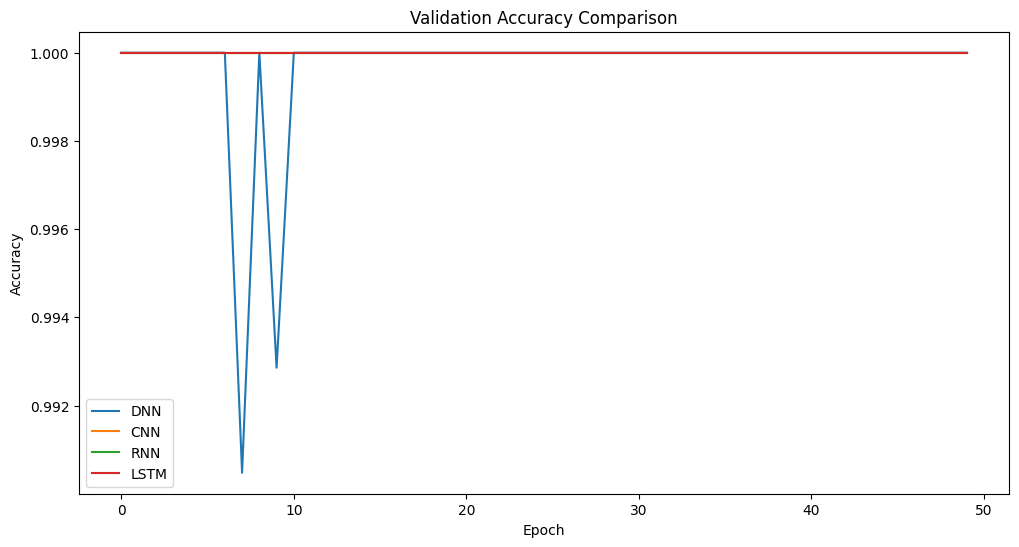

Final Results:
DNN: 100.00%
CNN: 100.00%
RNN: 100.00%
LSTM: 100.00%


In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Final Results:")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")


In [46]:
import tensorflow as tf

best_model = None
best_acc = 0
best_model_name = ""

# After training the models and getting results
for name, model in models.items():
    # Get the validation accuracy
    val_accuracy = histories[name].history['val_accuracy'][-1]
    
    # Save the model if it has the best validation accuracy
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model
        best_model_name = name  # Store the name of the best model
        # Save the best model in the current directory (or specify a path)
        best_model.save('best_model.h5')  # Saving as HDF5 file

print(f"Best Model ({best_model_name}) saved with validation accuracy: {best_acc * 100:.2f}%")


Best Model (DNN) saved with validation accuracy: 100.00%


In [47]:
df.describe()

,id,matematika,fisika,biologi,ekonomi,geografi,bahasa_inggris,bahasa_indonesia,ppkn,keterampilan,olahraga,sosiologi,komputer,iq,suka_sains,suka_bisnis,suka_kedokteran,suka_komputer,bermain_game
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,150.500000,28.980000,25.886667,22.280000,26.646667,28.570000,30.606667,28.906667,28.576667,29.953333,28.393333,32.033333,31.630000,34.473333,0.506667,0.166667,0.203333,0.230000,0.070000
std,86.622686,12.461148,10.764556,6.104043,8.727242,9.030906,8.876719,9.724350,7.707512,10.074033,7.112621,9.077709,11.493012,17.838932,0.500075,0.372767,0.402574,0.420933,0.255208
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.750000,18.000000,16.750000,19.000000,20.000000,24.000000,27.000000,21.000000,25.000000,22.000000,25.000000,28.000000,24.750000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,150.500000,30.000000,28.000000,22.000000,27.000000,29.000000,32.000000,34.000000,30.000000,32.500000,29.000000,33.000000,33.000000,35.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,225.250000,39.000000,35.000000,26.000000,34.000000,36.000000,37.000000,37.000000,34.000000,38.000000,34.000000,39.000000,41.000000,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,300.000000,50.000000,46.000000,34.000000,41.000000,41.000000,42.000000,39.000000,38.000000,45.000000,38.000000,44.000000,51.000000,71.000000,1.000000,1.000000,1.000000,1.000000,1.000000
